In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt", "r") as fp:
    words = fp.read().splitlines()

In [3]:
alphabet = sorted(list(set("".join(w for w in words))))
stoi = {ch: i + 1 for i, ch in enumerate(alphabet)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
block_size = 8

In [15]:
import typing as tp


def build_dataset(words: tp.List, block_size: int):
    X, Y = [], []
    for w in words:
        window = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(window)
            Y.append(ix)
            window = window[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

train_size = int(0.8 * len(words))
validation_size = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:train_size], block_size)
Xval, Yval = build_dataset(words[train_size:validation_size], block_size)
Xtest, Ytest = build_dataset(words[validation_size:], block_size)

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [6]:
import typing as tp


class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming_init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x) -> tp.Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> tp.List:
        return [self.weight] + ([] if self.bias is None else [self.bias])


# ------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training: bool = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x) -> tp.Any:
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> tp.List:
        return [self.gamma, self.beta]


# ------------------------------------------------------------------------
class Tanh:
    def __call__(self, x) -> tp.Any:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> tp.List:
        return []


# ------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x) -> tp.Any:
        return self.weight[x]

    def parameters(self) -> tp.List:
        return [self.weight]


# ------------------------------------------------------------------------
class Flatten:
    def __call__(self, x) -> tp.Any:
        return x.view(x.shape[0], -1)

    def parameters(self) -> tp.List:
        return []


# ------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers: tp.List) -> None:
        self.layers = layers

    def __call__(self, x) -> tp.Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self) -> tp.List:
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
torch.manual_seed(42)

In [17]:
n_embed = 10
n_hidden = 200

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        Flatten(),
        Linear(n_embed * block_size, n_hidden, bias=False),
        BatchNorm1d(dim=n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer makes less confident


parameters = model.parameters()
print(f"{sum(p.nelement() for p in parameters)} in total.")
for p in parameters:
    p.requires_grad = True

22097 in total.


In [18]:
# Training Loop
epochs = 200_000
batch_size = 32
lossi = []

for epoch in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if epoch < 150_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs:7d}: {loss.item():4f}")

    lossi.append(loss.log10().item())

0/ 200000: 4.029616
10000/ 200000: 1.866762
20000/ 200000: 2.321240
30000/ 200000: 2.210854
40000/ 200000: 2.352341
50000/ 200000: 2.240132
60000/ 200000: 2.501758
70000/ 200000: 2.174589
80000/ 200000: 2.178543
90000/ 200000: 2.144901
100000/ 200000: 1.902877
110000/ 200000: 2.311360
120000/ 200000: 1.871426
130000/ 200000: 2.053207
140000/ 200000: 2.109725
150000/ 200000: 1.824993
160000/ 200000: 1.488136
170000/ 200000: 1.865763
180000/ 200000: 2.361552
190000/ 200000: 2.094084


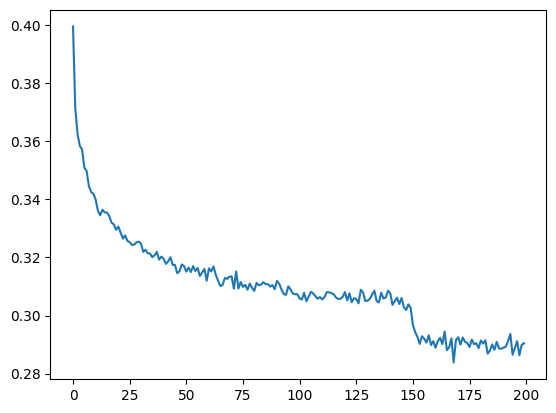

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [20]:
for layer in model.layers:
    layer.training = False

In [21]:
# Evaluation


@torch.no_grad()
def split_loss(split: str):
    x, y = {"train": (Xtr, Ytr), "val": (Xval, Yval), "test": (Xtest, Ytest)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.9175070524215698
val 2.0263478755950928


#### Performance Log

- original (3 character context + 200 hidden neurons, 12K params): train 2.059, val 2.108
- context: 3 -> 8 (22K params): train 1.917, val 2.026


In [22]:
# Sample

import torch

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    output = []
    context = [0] * block_size  # initialize with all "..."

    while True:
        logits = model(torch.tensor([context]))  # (1, block_size, embedding_size)
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]

        output.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in output))

carmah.
amelia.
khisming.
taty.
skarlen.
jazhuel.
deliah.
jarqui.
nellara.
chaiir.
